In [42]:
import sys
sys.path.append('..')
sys.path.append('../..')

import os
import numpy as np
import pandas as pd
import nitools as nt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from SUITPy import flatmap
import PcmPy as pcm
import scipy.stats as stats

import selective_recruitment.plotting as plotting
import selective_recruitment.globals as gl

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
from statsmodels.stats.anova import AnovaRM  # perform F test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from selective_recruitment.scripts.script_roi_differences import norm_within_category,prep_roi_comparison, plot_roi_differences

import warnings
warnings.filterwarnings('ignore')


wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'    
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'

# set up colors
colors = ['#FFC20A', # yellow
          '#0C7BDC', # blue
          ]
colors2 = ['#EF7F24', # orange 
           '#FA142B', # red
           '#7C30E1', # purple
           '#FFC20A', # yellow
           '#45C2EF', # light blue
           ]

seaborn_colors = ['#949494', # grey
                  '#BD926E', # brown
                  '#BA611B', # dark orange
                  '#C38820', # orange
                  '#F2B8E0', # pink
                  '#C283B5', # purple
                  '#158B6A', # green
                  '#176D9C', # blue
                  ]

seaborn_colors = [
                  '#176D9CFF', # blue
                  '#176D9C80', # blue
                  '#158B6AFF', # green
                  '#158B6A80', # green
                  '#FFC20AFF', # yellow
                  '#FFC20A80', # yellow
                  '#BA611BFF', # dark orange
                  '#BA611B80', # dark orange
                  ]

## Comparison of activity profiles within 4 quadrants of the multiple demand network.
Left - Right


Anterior - Posterior


In [43]:
df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym32AP_conn_reg.tsv")
D = pd.read_csv(df_path, sep="\t")
D, cond_map = prep_roi_comparison(D)
norm = 'mean'
cats = ['sn']

In [44]:
D = norm_within_category(D, category=cats, value='Y', norm=norm)
D = D.loc[D.roi != 0]
D = D.loc[D.cond_name != "rest"]
D["AP"] = D["roi_name"].str[4]

# mapping values of phase column to strings: 0->'encoding', 1->'retrieve'
D['phase_str'] = D['phase'].map({0: 'encoding', 1: 'retrieve'})

# load effect
D_load = D[(D.load == 6) & (D.recall == 1)]
DL2 = D[(D.load == 2) & (D.recall == 1)]
D_load["YL"] = D_load.Y.values - DL2.Y.values
D_load = norm_within_category(D_load, category=cats, value='YL', norm=norm)


# recall effect
D_recall = D[(D.recall == 0)]
D_fw = D[(D.recall == 1)]
D_recall["YL"] = D_recall.Y.values - D_fw.Y.values
D_recall = norm_within_category(D_recall, category=cats, value='YL', norm=norm)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
side          40.0782 1.0000 15.0000 0.0000
AP             1.5654 1.0000 15.0000 0.2300
phase          1.4767 1.0000 15.0000 0.2431
side:AP        5.2806 1.0000 15.0000 0.0364
side:phase     0.1173 1.0000 15.0000 0.7367
AP:phase      15.7882 1.0000 15.0000 0.0012
side:AP:phase  7.8474 1.0000 15.0000 0.0134

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
AP        3.7484 1.0000 15.0000 0.0719
phase     1.4326 1.0000 15.0000 0.2499
AP:phase 23.5265 1.0000 15.0000 0.0002



,group1,group2,meandiff,p-adj,lower,upper,reject
2,Aencoding,Pretrieve,0.0465,0.0,0.0313,0.0617,True
4,Aretrieve,Pretrieve,0.0411,0.0,0.0259,0.0563,True
5,Pencoding,Pretrieve,0.0362,0.0,0.0211,0.0514,True


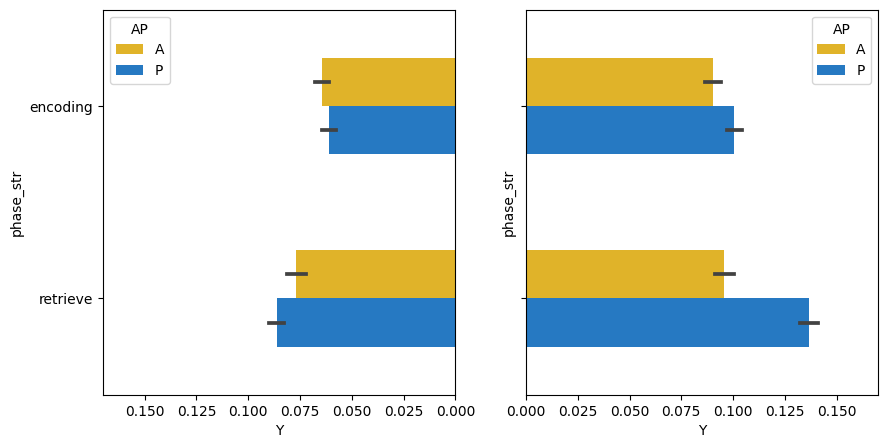

In [45]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

sns.barplot(data = D.loc[D.side == "L"], x = "Y", width = 0.5, hue = D.loc[D.side == "L"].AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, ax = axes[0])
# set the limist of the x axis
axes[0].set_xlim([0, 0.17])
# invert the horizontal axis
axes[0].invert_xaxis()

sns.barplot(data = D.loc[D.side == "R"], x = "Y", width = 0.5, hue = D.loc[D.side == "R"].AP, y = "phase_str", errorbar = "se", units = "sn", palette = colors, ax=axes[1])
# set the limist of the x axis
axes[1].set_xlim([0, 0.17])

# ax.set_xlim([-0.07, 0.07])
plt.savefig("topo_overall_barplot.pdf")

print(AnovaRM(data=D, depvar='Y',subject='sn', within=['side', 'AP', 'phase'], aggregate_func=np.mean).fit())

# two way anova only on right hemisphere
D_right = D.loc[D.side == "R"]
print(AnovaRM(data=D_right, depvar='Y',subject='sn', within=['AP', 'phase'], aggregate_func=np.mean).fit())

# post hoc test
T = pairwise_tukeyhsd(D_right.Y.values, D_right.AP+D_right.phase_str, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]
Tdf = Tdf[Tdf.reject == True]
Tdf

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
AP        0.0224 1.0000 15.0000 0.8829
phase     4.5318 1.0000 15.0000 0.0503
AP:phase  0.8080 1.0000 15.0000 0.3829



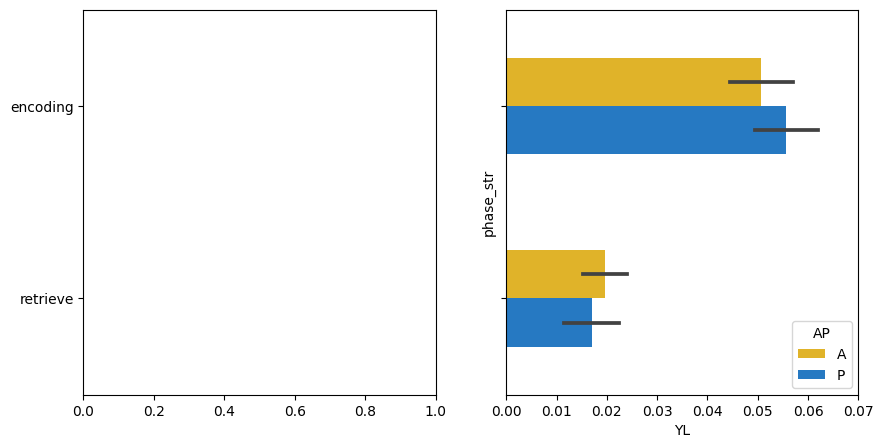

In [65]:
D_load_right = D_load.loc[D_load.side == "R"]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D_load_right, x = "YL", hue = D_load_right.AP, y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[1])

axes[1].set_xlim([0, 0.07])

# # Define some hatches
# hatches = ['+', '+', '+', '+']

# # Loop over the bars
# for i,thisbar in enumerate(ax.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')
    
plt.savefig("topo_load_AP_barplot.pdf")

# two way anova only on right hemisphere
print(AnovaRM(data=D_load_right, depvar='YL',subject='sn', within=['AP', 'phase'], aggregate_func=np.mean).fit())

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
AP        1.1250 1.0000 15.0000 0.3056
phase     0.0007 1.0000 15.0000 0.9785
AP:phase  0.3483 1.0000 15.0000 0.5638



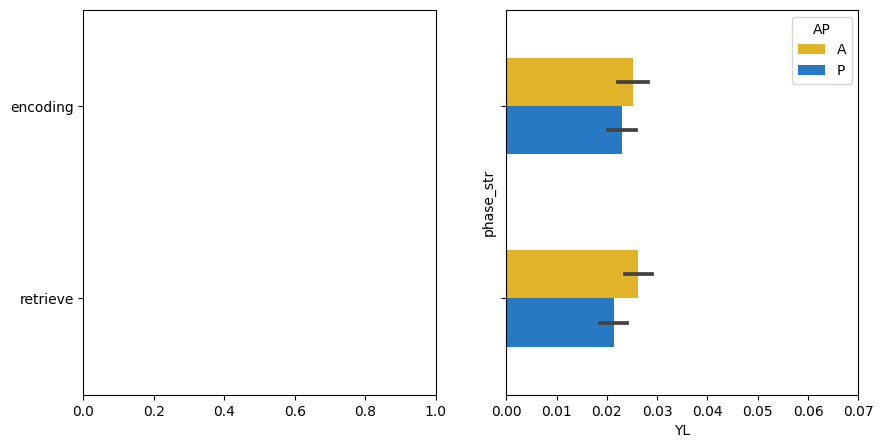

In [66]:
D_recall_right = D_recall.loc[D_recall.side == "R"]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
ax = sns.barplot(data = D_recall_right, x = "YL", hue = "AP", y = "phase_str", errorbar="se", units = "sn", palette = colors, width = 0.5, ax = axes[1])

axes[1].set_xlim([0, 0.07])



# hatches = ['\/', '\/', '\/', '\/']

# # Loop over the bars
# for i,thisbar in enumerate(ax.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')

plt.savefig("topo_recall_dir_AP_barplot.pdf")

# two way anova only on right hemisphere
print(AnovaRM(data=D_recall_right, depvar='YL',subject='sn', within=['AP', 'phase'], aggregate_func=np.mean).fit())


## Comparison of activity profiles within sub-regions of the multiple demand network
Left - Right

D1 - D2 - D3 - D4

In [50]:
df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym32_conn_reg.tsv")

D2 = pd.read_csv(df_path, sep="\t")
D2, cond_map = prep_roi_comparison(D2)
norm = 'mean'
cats = ['sn']

D2 = norm_within_category(D2, category=cats, value='Y', norm=norm)
D2 = D2.loc[D2.roi != 0]
D2 = D2.loc[D2.cond_name != "rest"]
D2["AP"] = D2["roi_name"].str[4]
# mapping values of phase column to strings: 0->'encoding', 1->'retrieve'
D2['phase_str'] = D2['phase'].map({0: 'encoding', 1: 'retrieve'})

# load effect
D2_load = D2[(D2.load == 6) & (D2.recall == 1)]
DL2 = D2[(D2.load == 2) & (D2.recall == 1)]
D2_load["YL"] = D2_load.Y.values - DL2.Y.values
D2_load = norm_within_category(D2_load, category=cats, value='YL', norm=norm)


# recall effect
D2_recall = D2[(D2.recall == 0)]
D2_fw = D2[(D2.recall == 1)]
D2_recall["YL"] = D2_recall.Y.values - D2_fw.Y.values
D2_recall = norm_within_category(D2_recall, category=cats, value='YL', norm=norm)

# change colors
# seaborn_colors = [
#                   '#45C2EFFF', # light blue
#                 #   '#45C2EF80', # light blue
#                   '#158B6AFF', # green
#                 #   '#158B6A80', # green
#                   '#C283B5FF', # purple
#                 #   '#C283B580', # purple
#                   '#BA611BFF', # dark orange
#                 #   '#BA611B80', # dark orange
#                   ]
seaborn_colors = [
                #   '#45C2EFFF', # light blue
                  '#45C2EFFF', # light blue
                  '#158B6AFF', # green
                  '#C283B5FF', # purple
                  '#BA611BFF', # dark orange
                  ]

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
phase          1.5213 1.0000 15.0000 0.2364
roi_sub       31.9348 3.0000 45.0000 0.0000
phase:roi_sub  2.9790 3.0000 45.0000 0.0413



,group1,group2,meandiff,p-adj,lower,upper,reject
0,encoding1,encoding2,-0.0654,0.0000,-0.0968,-0.0341,True
2,encoding1,encoding4,-0.0372,0.0081,-0.0686,-0.0058,True
4,encoding1,retrieve2,-0.0504,0.0000,-0.0817,-0.0190,True
5,encoding1,retrieve3,0.0540,0.0000,0.0226,0.0853,True
7,encoding2,encoding3,0.0916,0.0000,0.0602,0.1230,True
9,encoding2,retrieve1,0.0790,0.0000,0.0476,0.1104,True
11,encoding2,retrieve3,0.1194,0.0000,0.0880,0.1508,True
12,encoding2,retrieve4,0.0571,0.0000,0.0257,0.0885,True
13,encoding3,encoding4,-0.0633,0.0000,-0.0947,-0.0319,True
15,encoding3,retrieve2,-0.0765,0.0000,-0.1079,-0.0451,True


,group1,group2,meandiff,p-adj,lower,upper,reject
0,encoding1,encoding2,-0.0654,0.0000,-0.0968,-0.0341,True
2,encoding1,encoding4,-0.0372,0.0081,-0.0686,-0.0058,True
7,encoding2,encoding3,0.0916,0.0000,0.0602,0.1230,True
13,encoding3,encoding4,-0.0633,0.0000,-0.0947,-0.0319,True
22,retrieve1,retrieve2,-0.0639,0.0000,-0.0953,-0.0325,True
23,retrieve1,retrieve3,0.0404,0.0025,0.0090,0.0718,True
25,retrieve2,retrieve3,0.1043,0.0000,0.0729,0.1357,True
26,retrieve2,retrieve4,0.0420,0.0013,0.0106,0.0734,True
27,retrieve3,retrieve4,-0.0623,0.0000,-0.0937,-0.0309,True


,group1,group2,meandiff,p-adj,lower,upper,reject


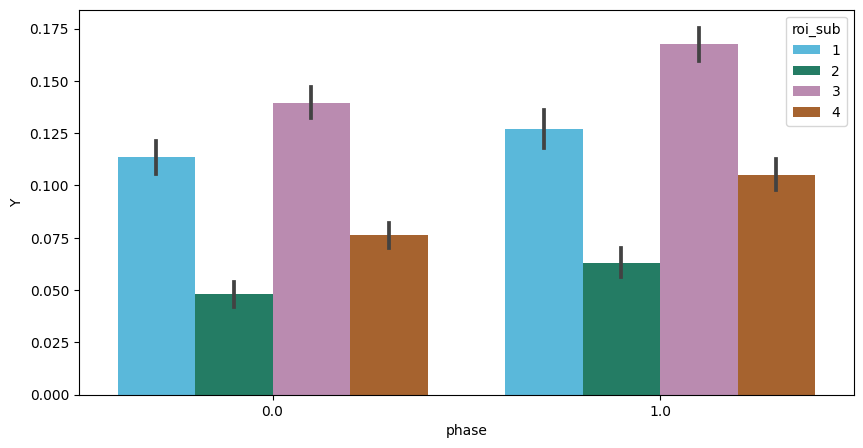

In [67]:
D_right = D2.loc[D2.side == "R"]
# during encoding
fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)

ax = sns.barplot(data = D_right, y = "Y", hue = "roi_sub", x = "phase", errorbar="se", units = "sn", ax = axes, palette=seaborn_colors)
plt.savefig("topo_right_sub_barplot.pdf")

print(AnovaRM(data=D_right, depvar='Y',subject='sn', within=['phase', 'roi_sub'], aggregate_func=np.mean).fit())

T = pairwise_tukeyhsd(D_right.Y.values, D_right.phase_str+D_right.roi_sub, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]


Tdf = Tdf[Tdf.reject == True]
display(Tdf)
idx = ((Tdf.group1.str[0:8] == Tdf.group2.str[0:8])&(Tdf.group1.str[9] != Tdf.group2.str[9]))
A = Tdf.loc[idx]
display(A)

Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0:8] != Tdf.group2.str[0:8])&(Tdf.group1.str[9] == Tdf.group2.str[9]))
B = Tdf.loc[idx]
display(B)

In [52]:
# df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym32AP_conn_reg.tsv")

# D2 = pd.read_csv(df_path, sep="\t")
# D2, cond_map = prep_roi_comparison(D2)
# norm = 'mean'
# cats = ['sn']

# D2 = norm_within_category(D2, category=cats, value='Y', norm=norm)
# D2 = D2.loc[D2.roi != 0]
# D2 = D2.loc[D2.cond_name != "rest"]
# D2["AP"] = D2["roi_name"].str[4]
# # mapping values of phase column to strings: 0->'encoding', 1->'retrieve'
# D2['phase_str'] = D2['phase'].map({0: 'encoding', 1: 'retrieve'})

# # load effect
# D2_load = D2[(D2.load == 6) & (D2.recall == 1)]
# DL2 = D2[(D2.load == 2) & (D2.recall == 1)]
# D2_load["YL"] = D2_load.Y.values - DL2.Y.values
# D2_load = norm_within_category(D2_load, category=cats, value='YL', norm=norm)


# # recall effect
# D2_recall = D2[(D2.recall == 0)]
# D2_fw = D2[(D2.recall == 1)]
# D2_recall["YL"] = D2_recall.Y.values - D2_fw.Y.values
# D2_recall = norm_within_category(D2_recall, category=cats, value='YL', norm=norm)

# # change colors
# seaborn_colors = [
#                   '#45C2EFFF', # light blue
#                 #   '#45C2EF80', # light blue
#                   '#158B6AFF', # green
#                 #   '#158B6A80', # green
#                   '#C283B5FF', # purple
#                 #   '#C283B580', # purple
#                   '#BA611BFF', # dark orange
#                 #   '#BA611B80', # dark orange
#                   ]

# D_right = D2.loc[D2.side == "R"]
# phase = 0
# D_phase = D_right.loc[D_right.phase == phase]
# # during encoding
# fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)

# ax = sns.barplot(data = D_phase, y = "Y", hue = "roi_sub", x = "AP", errorbar="se", units = "sn", ax = axes)

# print(AnovaRM(data=D_phase, depvar='Y',subject='sn', within=['AP', 'roi_sub'], aggregate_func=np.mean).fit())

# T = pairwise_tukeyhsd(D_right.Y.values, D_right.AP+D_right.roi_sub, alpha=0.05)
# Tdf = pd.DataFrame(T._results_table.data[1:])
# Tdf.columns = T._results_table.data[0]


# Tdf = Tdf[Tdf.reject == True]
# # display(Tdf)
# idx = ((Tdf.group1.str[0] == Tdf.group2.str[0])&(Tdf.group1.str[1] != Tdf.group2.str[1]))
# A = Tdf.loc[idx]
# display(A)

# Tdf = Tdf[Tdf.reject == True]
# idx = ((Tdf.group1.str[0] != Tdf.group2.str[0])&(Tdf.group1.str[1] == Tdf.group2.str[1]))
# B = Tdf.loc[idx]
# display(B)


In [53]:
# # D_right = D2.loc[D2.side == "R"]
# phase = 1
# D_phase = D2.loc[D2.phase == phase]
# # during encoding
# fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)

# ax = sns.barplot(data = D_phase, y = "Y", hue = "roi_sub", x = "side", errorbar="se", units = "sn", ax = axes, palette=seaborn_colors)

# print(AnovaRM(data=D_phase, depvar='Y',subject='sn', within=['side', 'roi_sub'], aggregate_func=np.mean).fit())

# T = pairwise_tukeyhsd(D_right.Y.values, D_right.side+D_right.roi_sub, alpha=0.05)
# Tdf = pd.DataFrame(T._results_table.data[1:])
# Tdf.columns = T._results_table.data[0]


# Tdf = Tdf[Tdf.reject == True]
# display(Tdf)
# # idx = ((Tdf.group1.str[0:8] == Tdf.group2.str[0:8])&(Tdf.group1.str[9] != Tdf.group2.str[9]))
# # A = Tdf.loc[idx]
# # display(A)

# # Tdf = Tdf[Tdf.reject == True]
# # idx = ((Tdf.group1.str[0:8] != Tdf.group2.str[0:8])&(Tdf.group1.str[9] == Tdf.group2.str[9]))
# # B = Tdf.loc[idx]
# # display(B)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
phase          4.2546 1.0000 15.0000 0.0569
roi_sub       15.1569 3.0000 45.0000 0.0000
phase:roi_sub  2.4724 3.0000 45.0000 0.0738



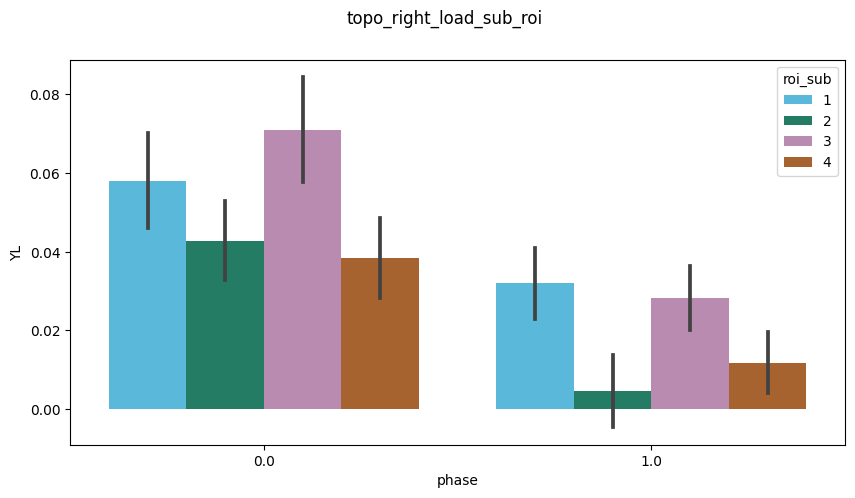

In [73]:
D_load_right = D2_load.loc[D2_load.side == "R"]
fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)
ax = sns.barplot(data = D_load_right, y = "YL", hue = "roi_sub", x = "phase", errorbar="se", units = "sn", ax = axes, palette=seaborn_colors)
# axes[1].set_xlim([-0.01, 0.1])
fig.suptitle("topo_right_load_sub_roi")

# # Define some hatches
# hatches = ['++', '++', '++', '++', '++', '++', '++', '++']

# # Loop over the bars
# for i,thisbar in enumerate(axes.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')

plt.savefig("topo_load_right_sub_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D_load_right, depvar='YL',subject='sn', within=['phase', 'roi_sub'], aggregate_func=np.mean).fit())


In [55]:
# D_load_right = D2_load.loc[D2_load.side == "R"]
# phase = 1
# D_phase = D_load_right.loc[D_load_right.phase == phase]
# fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)
# ax = sns.barplot(data = D_load_right, y = "YL", hue = "roi_sub", x = "AP", errorbar="se", units = "sn", ax = axes)
# # axes[1].set_xlim([-0.01, 0.1])
# fig.suptitle("load_sub_roi")

# # Define some hatches
# hatches = ['++', '++', '++', '++', '++', '++', '++', '++']

# # Loop over the bars
# for i,thisbar in enumerate(axes.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')

# plt.savefig("topo_recall_right_barplot.pdf")

# # sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
# print(AnovaRM(data=D_load_right, depvar='YL',subject='sn', within=['AP', 'roi_sub'], aggregate_func=np.mean).fit())


                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
phase          0.0017 1.0000 15.0000 0.9677
roi_sub        7.2971 3.0000 45.0000 0.0004
phase:roi_sub  5.3215 3.0000 45.0000 0.0032



,group1,group2,meandiff,p-adj,lower,upper,reject
0,encoding1,encoding2,-0.0682,0.0002,-0.1143,-0.0222,True
7,encoding2,encoding3,0.0917,0.0000,0.0457,0.1378,True
13,encoding3,encoding4,-0.0636,0.0008,-0.1096,-0.0175,True
22,retrieve1,retrieve2,-0.0755,0.0000,-0.1216,-0.0294,True
25,retrieve2,retrieve3,0.1122,0.0000,0.0661,0.1582,True
27,retrieve3,retrieve4,-0.0664,0.0004,-0.1125,-0.0203,True


,group1,group2,meandiff,p-adj,lower,upper,reject


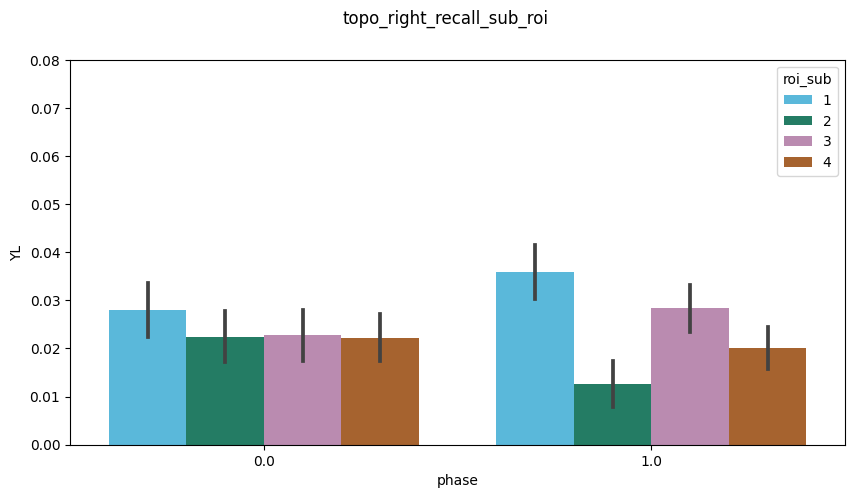

In [72]:
D_recall_right = D2_recall.loc[D2_recall.side == "R"]
fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)
ax = sns.barplot(data = D_recall_right, y = "YL", hue = "roi_sub", x = "phase", errorbar="se", units = "sn", ax = axes, palette=seaborn_colors)
axes.set_ylim([0, 0.08])
fig.suptitle("topo_right_recall_sub_roi")

# Define some hatches
# hatches = ['\/', '\/', '\/', '\/', '\/', '\/', '\/', '\/']

# # Loop over the bars
# for i,thisbar in enumerate(axes.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')

plt.savefig("topo_recall_dir_right_sub_barplot.pdf")

# sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
print(AnovaRM(data=D_recall_right, depvar='YL',subject='sn', within=['phase', 'roi_sub'], aggregate_func=np.mean).fit())


T = pairwise_tukeyhsd(D_recall_right.Y.values, D_recall_right.phase_str+D_recall_right.roi_sub, alpha=0.05)
Tdf = pd.DataFrame(T._results_table.data[1:])
Tdf.columns = T._results_table.data[0]


Tdf = Tdf[Tdf.reject == True]
# display(Tdf)
idx = ((Tdf.group1.str[0:8] == Tdf.group2.str[0:8])&(Tdf.group1.str[9] != Tdf.group2.str[9]))
A = Tdf.loc[idx]
display(A)

Tdf = Tdf[Tdf.reject == True]
idx = ((Tdf.group1.str[0:8] != Tdf.group2.str[0:8])&(Tdf.group1.str[9] == Tdf.group2.str[9]))
B = Tdf.loc[idx]
display(B)

In [ ]:
# D_recall_right = D2_recall.loc[D2_recall.side == "R"]
# phase = 1
# D_phase = D_recall_right.loc[D_recall_right.phase == phase]
# fig, axes = plt.subplots(figsize=(10,5), ncols=1, sharey=True)
# ax = sns.barplot(data = D_phase, y = "YL", hue = "roi_sub", x = "AP", errorbar="se", units = "sn", ax = axes)
# # axes[1].set_xlim([-0.01, 0.1])
# fig.suptitle("load_sub_roi")

# # Define some hatches
# hatches = ['++', '++', '++', '++', '++', '++', '++', '++']

# # Loop over the bars
# for i,thisbar in enumerate(axes.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])
#     thisbar.set_edgecolor('black')

# plt.savefig("topo_recall_right_barplot.pdf")

# # sns.barplot(data = D.loc[D.phase == 1], x = "roi_sub", hue = D.side + D.AP, y = "Y", ci = 70, units = "sn", palette = "colorblind")
# print(AnovaRM(data=D_phase, depvar='YL',subject='sn', within=['AP', 'roi_sub'], aggregate_func=np.mean).fit())
